In [2]:
# Cell 1: Imports and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import os

# Set matplotlib to inline (Jupyter-like)
%matplotlib inline

data_path = "/kaggle/input/sensor1data/Copy of ESP32 Data - Snsor 1.csv"
assert os.path.exists(data_path), f"Data file not found at {data_path}"

df = pd.read_csv(data_path)
print("Loaded shape:", df.shape)
df.head(10)


Loaded shape: (650, 7)


,Timestamp,MAX6675_TEMP_C,Custom_ADC,Custom_Vout,Custom_Resistance,Env_Temp_C,Env_Humidity_%
0,10/3/2025 22:20:17,23.50,2919,2.352,4028.78,26.02,54.34
1,10/3/2025 22:20:29,23.75,2919,2.352,4028.78,25.68,54.94
2,10/3/2025 22:20:41,23.50,2921,2.354,4019.17,25.37,56.44
3,10/3/2025 22:20:52,23.50,2901,2.338,4115.82,25.09,56.47
4,10/3/2025 22:21:04,23.00,2923,2.356,4009.58,24.84,56.71
5,10/3/2025 22:21:16,23.75,2925,2.357,4000.00,24.64,58.70
6,10/3/2025 22:21:26,23.50,2924,2.356,4004.79,24.46,57.85
7,10/3/2025 22:21:39,23.00,2889,2.328,4174.45,24.29,59.62
8,10/3/2025 22:21:49,23.75,2923,2.356,4009.58,24.19,60.45
9,10/3/2025 22:21:59,23.75,2922,2.355,4014.37,24.10,60.15


In [3]:
# Cell 2: Basic cleaning and type fixes
df = df.rename(columns={
    "MAX6675_TEMP_C": "T_hotplate",
    "Custom_Resistance": "R",
    "Env_Temp_C": "T_env",
    "Env_Humidity_%": "H"
})

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['T_hotplate','R','T_env','H']).reset_index(drop=True)
df = df.drop_duplicates(subset=['T_hotplate','R'])
print("After cleaning shape:", df.shape)
df[['Timestamp','T_hotplate','R','T_env','H']].head(10)


After cleaning shape: (634, 7)


,Timestamp,T_hotplate,R,T_env,H
0,2025-10-03 22:20:17,23.50,4028.78,26.02,54.34
1,2025-10-03 22:20:29,23.75,4028.78,25.68,54.94
2,2025-10-03 22:20:41,23.50,4019.17,25.37,56.44
3,2025-10-03 22:20:52,23.50,4115.82,25.09,56.47
4,2025-10-03 22:21:04,23.00,4009.58,24.84,56.71
5,2025-10-03 22:21:16,23.75,4000.00,24.64,58.70
6,2025-10-03 22:21:26,23.50,4004.79,24.46,57.85
7,2025-10-03 22:21:39,23.00,4174.45,24.29,59.62
8,2025-10-03 22:21:49,23.75,4009.58,24.19,60.45
9,2025-10-03 22:21:59,23.75,4014.37,24.10,60.15


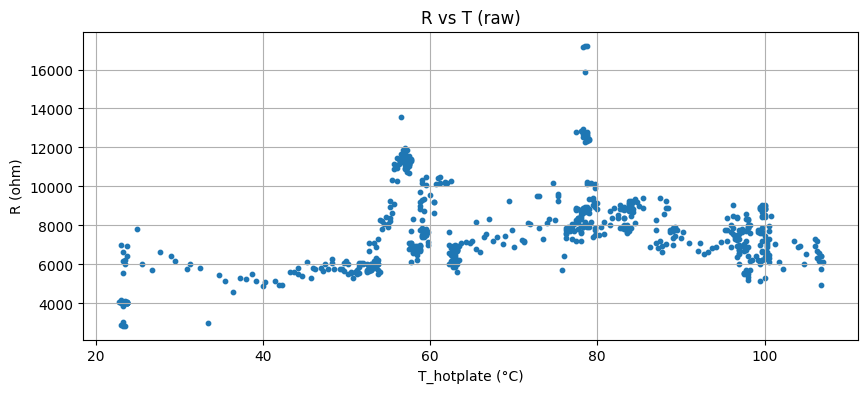

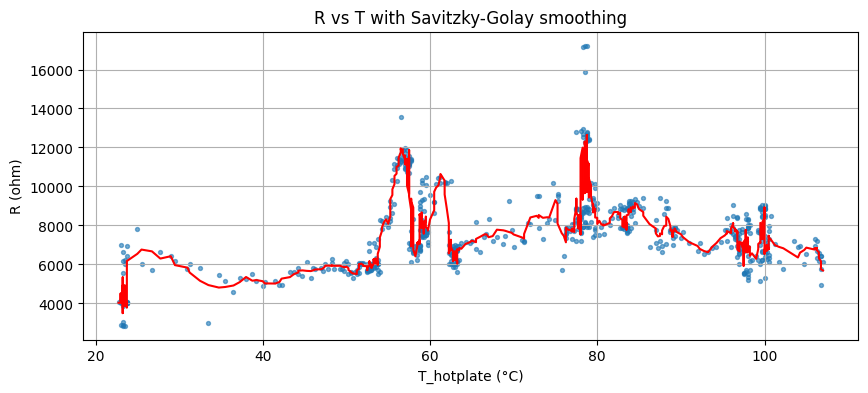

In [8]:
# Cell 3: Basic EDA plots (R vs T, with smoothing)
plt.figure(figsize=(10,4))
plt.scatter(df['T_hotplate'], df['R'], s=10)
plt.xlabel('T_hotplate (°C)'); plt.ylabel('R (ohm)')
plt.title('R vs T (raw)')
plt.grid(True)
plt.show()

df = df.sort_values('T_hotplate').reset_index(drop=True)
window = 11 if len(df)>11 else 5
df['R_smooth'] = savgol_filter(df['R'].values, window_length=window, polyorder=3)

plt.figure(figsize=(10,4))
plt.scatter(df['T_hotplate'], df['R'], s=8, alpha=0.6)
plt.plot(df['T_hotplate'], df['R_smooth'], color='red')
plt.xlabel('T_hotplate (°C)'); plt.ylabel('R (ohm)')
plt.title('R vs T with Savitzky-Golay smoothing')
plt.grid(True)
plt.show()


In [9]:
# Cell 4: Segment detection and IQR outlier removal
df = df.sort_values('Timestamp').reset_index(drop=True)
df['T_diff'] = df['T_hotplate'].diff().fillna(0)
df['run_id'] = (df['T_diff'].abs() > 0.5).cumsum()  # new run if temp jump > 0.5

clean_segments = []
for rid, g in df.groupby('run_id'):
    if len(g) < 5:
        continue
    g2 = g[g['R'].between(g['R'].quantile(0.01), g['R'].quantile(0.99))]
    q1, q3 = g2['R'].quantile(0.25), g2['R'].quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    g3 = g2[g2['R'].between(low, high)]
    if len(g3) >= 3:
        clean_segments.append(g3)

clean_df = pd.concat(clean_segments, ignore_index=True)
print("After segment-wise outlier removal shape:", clean_df.shape)

clean_df = clean_df.sort_values('T_hotplate').reset_index(drop=True)
clean_df['R_smooth'] = savgol_filter(
    clean_df['R'].values,
    window_length=11 if len(clean_df)>11 else 5,
    polyorder=3
)
clean_df[['Timestamp','T_hotplate','R','R_smooth']].head(10)


After segment-wise outlier removal shape: (464, 10)


,Timestamp,T_hotplate,R,R_smooth
0,2025-10-03 22:23:02,22.75,4062.50,4640.151958
1,2025-10-03 22:24:18,23.00,4077.00,3470.689021
2,2025-10-03 22:25:33,23.00,2881.41,2958.330699
3,2025-10-03 22:22:33,23.25,4077.00,2949.896049
4,2025-10-03 22:25:43,23.25,3062.20,3292.204126
5,2025-10-03 22:25:20,23.25,2861.18,3832.073986
6,2025-10-03 22:23:12,23.25,4067.33,4047.557296
7,2025-10-03 22:24:39,23.25,3843.81,4560.965501
8,2025-10-03 22:26:49,23.25,6153.85,4771.605291
9,2025-10-03 22:26:17,23.25,6626.07,5030.004639


In [6]:
# Cell 5: Piecewise polynomial fit R = f(T,H) for 3 temperature ranges
bins = [ -np.inf, 50, 80, np.inf ]
clean_df['T_bin'] = pd.cut(clean_df['T_hotplate'], bins=bins, labels=[1,2,3])

segment_results = {}
for seg in [1,2,3]:
    g = clean_df[clean_df['T_bin']==seg]
    if len(g) < 10:
        continue
    X = g[['T_hotplate','H']].values
    poly = PolynomialFeatures(degree=4, include_bias=False)
    Xp = poly.fit_transform(X)
    model = LinearRegression().fit(Xp, g['R'].values)
    pred = model.predict(Xp)
    r2 = r2_score(g['R'].values, pred)
    rmse = mean_squared_error(g['R'].values, pred, squared=False)
    segment_results[seg] = {'model': model, 'poly': poly, 'r2': r2, 'rmse': rmse, 'n': len(g)}
    print(f"Segment {seg}: n={len(g):d}, R²={r2:.3f}, RMSE={rmse:.2f}")


Segment 1: n=33, R²=0.361, RMSE=885.10
Segment 2: n=257, R²=0.441, RMSE=1637.48
Segment 3: n=174, R²=0.479, RMSE=693.15


In [10]:
# Cell 5: Piecewise polynomial fit R = f(T,H)
bins = [-np.inf, 50, 80, np.inf]
clean_df['T_bin'] = pd.cut(clean_df['T_hotplate'], bins=bins, labels=[1,2,3])

segment_results = {}
for seg in [1,2,3]:
    g = clean_df[clean_df['T_bin']==seg]
    if len(g) < 10:
        continue
    X = g[['T_hotplate','H']].values
    poly = PolynomialFeatures(degree=4, include_bias=False)
    Xp = poly.fit_transform(X)
    model = LinearRegression().fit(Xp, g['R'].values)
    pred = model.predict(Xp)
    r2 = r2_score(g['R'].values, pred)
    rmse = mean_squared_error(g['R'].values, pred, squared=False)
    segment_results[seg] = {'model': model, 'poly': poly, 'r2': r2, 'rmse': rmse, 'n': len(g)}
    print(f"Segment {seg}: n={len(g)}, R²={r2:.3f}, RMSE={rmse:.2f}")


Segment 1: n=33, R²=0.361, RMSE=885.10
Segment 2: n=257, R²=0.441, RMSE=1637.48
Segment 3: n=174, R²=0.479, RMSE=693.15


In [11]:
# Cell 6: Direct model T = f(R, T_env, H) with Gradient Boosting
X = clean_df[['R','T_env','H']].values
y = clean_df['T_hotplate'].values

gbr = GradientBoostingRegressor(n_estimators=500, max_depth=4, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(gbr, X, y, cv=kf, scoring='r2')
rmse_scores = np.sqrt(-cross_val_score(gbr, X, y, cv=kf, scoring='neg_mean_squared_error'))

print("GBR CV R² scores:", np.round(r2_scores,3))
print("GBR CV mean R²:", np.round(r2_scores.mean(),3))
print("GBR CV RMSE (°C):", np.round(rmse_scores,2))
print("Mean RMSE (°C):", np.round(rmse_scores.mean(),2))

# Fit final model on full cleaned data and save
gbr.fit(X, y)
y_pred = gbr.predict(X)
print("Train R²:", r2_score(y, y_pred))
print("Train RMSE (°C):", mean_squared_error(y, y_pred, squared=False))

# ✅ save model in Kaggle working directory
model_path = "/kaggle/working/sensor1_T_from_R_model.pkl"
joblib.dump({'model': gbr}, model_path)
print("Saved model to", model_path)


GBR CV R² scores: [0.798 0.742 0.704 0.808 0.858]
GBR CV mean R²: 0.782
GBR CV RMSE (°C): [10.85 10.85 10.11  8.5   7.45]
Mean RMSE (°C): 9.55
Train R²: 0.9993870895808221
Train RMSE (°C): 0.513793642782141
Saved model to /kaggle/working/sensor1_T_from_R_model.pkl


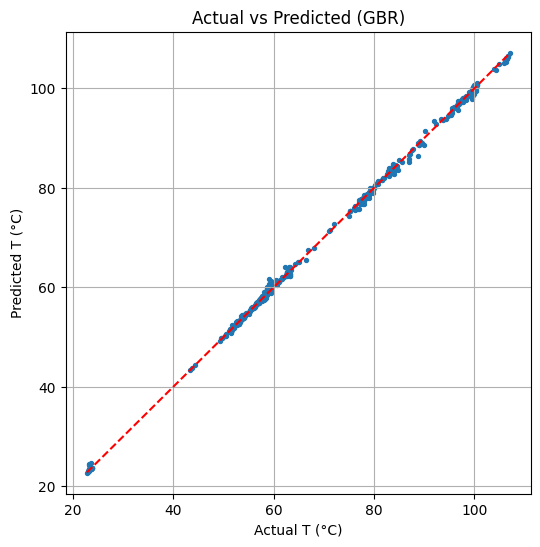

Surrogate poly degree2 R²: 0.5088034403417183 RMSE: 14.545139219183689
Saved surrogate to /kaggle/working/sensor1_surrogate_poly_deg2.pkl


In [12]:
# Cell 7: Actual vs Predicted (GBR) + lightweight polynomial surrogate
plt.figure(figsize=(6,6))
plt.scatter(clean_df['T_hotplate'], y_pred, s=8)
plt.plot(
    [clean_df['T_hotplate'].min(), clean_df['T_hotplate'].max()],
    [clean_df['T_hotplate'].min(), clean_df['T_hotplate'].max()],
    'r--'
)
plt.xlabel('Actual T (°C)')
plt.ylabel('Predicted T (°C)')
plt.title('Actual vs Predicted (GBR)')
plt.grid(True)
plt.show()

# Fit degree-2 polynomial surrogate
poly2 = PolynomialFeatures(degree=2, include_bias=False)
Xp = poly2.fit_transform(clean_df[['R','T_env','H']])
lr_small = LinearRegression().fit(Xp, clean_df['T_hotplate'])
pred_small = lr_small.predict(Xp)
print("Surrogate poly degree2 R²:",
      r2_score(clean_df['T_hotplate'], pred_small),
      "RMSE:",
      mean_squared_error(clean_df['T_hotplate'], pred_small, squared=False))

surrogate_path = "/kaggle/working/sensor1_surrogate_poly_deg2.pkl"
joblib.dump({'poly': poly2, 'model': lr_small}, surrogate_path)
print("Saved surrogate to", surrogate_path)


In [13]:
# Cell 8: Save cleaned dataframe
cleaned_path = "/kaggle/working/sensor1_cleaned.csv"
clean_df.to_csv(cleaned_path, index=False)
print("Cleaned CSV saved to", cleaned_path)
print("Model files:")
print(model_path)
print(surrogate_path)


Cleaned CSV saved to /kaggle/working/sensor1_cleaned.csv
Model files:
/kaggle/working/sensor1_T_from_R_model.pkl
/kaggle/working/sensor1_surrogate_poly_deg2.pkl


# Equations

In [14]:
# Cell A: Load surrogate polynomial and print the readable equation
import joblib
import numpy as np

surrogate_path = "/kaggle/working/sensor1_surrogate_poly_deg2.pkl"
obj = joblib.load(surrogate_path)
poly = obj['poly']     # PolynomialFeatures object
model = obj['model']   # LinearRegression object

feature_names = ['R','T_env','H']
# get transformed feature names (sklearn gives no built-in names, build them)
from itertools import combinations_with_replacement
def poly_feature_names(base_names, degree):
    # generate names for PolynomialFeatures(include_bias=False)
    names = []
    n = len(base_names)
    for deg in range(1, degree+1):
        for comb in combinations_with_replacement(range(n), deg):
            name = "*".join(base_names[i] for i in comb)
            names.append(name)
    return names

degree = 2
names = poly_feature_names(feature_names, degree)
coefs = model.coef_
intercept = model.intercept_

print("Surrogate polynomial (degree 2) — human readable:")
eq_parts = [f"{intercept:.6g}"]
for c, n in zip(coefs, names):
    eq_parts.append(f"{c:.6g}*{n}")
print("T ≈ " + " + ".join(eq_parts))

# Optionally show R² of surrogate on cleaned data
import pandas as pd
cleaned = pd.read_csv("/kaggle/working/sensor1_cleaned.csv")
Xp = poly.transform(cleaned[feature_names])
pred = model.predict(Xp)
from sklearn.metrics import r2_score, mean_squared_error
print("Surrogate R² on cleaned data:", round(r2_score(cleaned['T_hotplate'], pred), 4))
print("Surrogate RMSE (°C):", round(mean_squared_error(cleaned['T_hotplate'], pred, squared=False), 4))


Surrogate polynomial (degree 2) — human readable:
T ≈ -3336.43 + 0.142331*R + 2.39983*T_env + 58.0308*H + -1.56191e-06*R*R + 0.00307714*R*T_env + -0.00296374*R*H + -0.687616*T_env*T_env + 1.19804*T_env*H + -0.446658*H*H
Surrogate R² on cleaned data: 0.5088
Surrogate RMSE (°C): 14.5451


In [15]:
# Cell B: Load GBR, distill into a polynomial regression (degree selectable), print equation
import joblib
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

gbr_path = "/kaggle/working/sensor1_T_from_R_model.pkl"
gbr_obj = joblib.load(gbr_path)
gbr = gbr_obj['model'] if isinstance(gbr_obj, dict) and 'model' in gbr_obj else gbr_obj

cleaned = pd.read_csv("/kaggle/working/sensor1_cleaned.csv")
X = cleaned[['R','T_env','H']].values
y = cleaned['T_hotplate'].values

# make GBR predictions (the teacher)
y_gbr = gbr.predict(X)

# Distill: fit polynomial degree d to approximate GBR
degree = 3   # try 3 or 4 (trade-off: higher degree => larger equation & possible overfit)
poly = PolynomialFeatures(degree=degree, include_bias=False)
Xp = poly.fit_transform(cleaned[['R','T_env','H']])
lr = LinearRegression().fit(Xp, y_gbr)  # fit to gbr predictions

# Print readable equation
# build names
from itertools import combinations_with_replacement
feature_names = ['R','T_env','H']
def poly_feature_names(base_names, degree):
    names = []
    n = len(base_names)
    for deg in range(1, degree+1):
        for comb in combinations_with_replacement(range(n), deg):
            name = "*".join(base_names[i] for i in comb)
            names.append(name)
    return names

names = poly_feature_names(feature_names, degree)
coefs = lr.coef_
intercept = lr.intercept_

print(f"Distilled polynomial (degree {degree}) approximating GBR:")
eq_parts = [f"{intercept:.6g}"]
for c, n in zip(coefs, names):
    eq_parts.append(f"{c:.6g}*{n}")
print("T ≈ " + " + ".join(eq_parts))

# Evaluate how well distilled poly matches GBR and true T
y_distilled = lr.predict(Xp)
print("R² (distilled vs GBR):", round(r2_score(y_gbr, y_distilled),4))
print("R² (distilled vs true T):", round(r2_score(y, y_distilled),4))
print("RMSE (distilled vs true T):", round(mean_squared_error(y, y_distilled, squared=False),4))


Distilled polynomial (degree 3) approximating GBR:
T ≈ 37576.4 + -9.08722*R + -4621.97*T_env + 1769.52*H + 0.000132565*R*R + 0.0466556*R*T_env + 0.241068*R*H + 59.7845*T_env*T_env + 52.3176*T_env*H + -57.0643*H*H + 8.17467e-11*R*R*R + -3.22411e-06*R*R*T_env + -1.0088e-06*R*R*H + 0.00480438*R*T_env*T_env + -0.00335869*R*T_env*H + -0.00120495*R*H*H + 1.5877*T_env*T_env*T_env + -2.74321*T_env*T_env*H + 0.977132*T_env*H*H + 0.236193*H*H*H
R² (distilled vs GBR): 0.6904
R² (distilled vs true T): 0.6828
RMSE (distilled vs true T): 11.6881


In [16]:
# Cell C: Fit explicit polynomials T = f(R, T_env, H) overall and piecewise, print equations
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

cleaned = pd.read_csv("/kaggle/working/sensor1_cleaned.csv")
feature_names = ['R','T_env','H']

def fit_and_print(df, degree=4, label="overall"):
    X = df[feature_names].values
    y = df['T_hotplate'].values
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xp = poly.fit_transform(X)
    lr = LinearRegression().fit(Xp, y)
    # build feature names
    from itertools import combinations_with_replacement
    def poly_feature_names(base_names, degree):
        names = []
        n = len(base_names)
        for deg in range(1, degree+1):
            for comb in combinations_with_replacement(range(n), deg):
                name = "*".join(base_names[i] for i in comb)
                names.append(name)
        return names
    names = poly_feature_names(feature_names, degree)
    print(f"\nPolynomial degree {degree} — fitted on {label} (n={len(df)}):")
    eq_parts = [f"{lr.intercept_:.6g}"]
    for c, n in zip(lr.coef_, names):
        eq_parts.append(f"{c:.6g}*{n}")
    print("T = " + " + ".join(eq_parts))
    print("R²:", round(r2_score(y, lr.predict(Xp)),4),
          "RMSE (°C):", round(mean_squared_error(y, lr.predict(Xp), squared=False),4))
    return lr, poly

# Overall fit (degree 4)
lr_overall, poly_overall = fit_and_print(cleaned, degree=4, label="overall cleaned data")

# Piecewise: choose bins in T_hotplate and fit per bin
bins = [-np.inf, 50, 80, np.inf]
cleaned['T_bin'] = pd.cut(cleaned['T_hotplate'], bins=bins, labels=[1,2,3])
for seg in [1,2,3]:
    g = cleaned[cleaned['T_bin']==seg]
    if len(g) >= 10:
        fit_and_print(g, degree=4, label=f"segment {seg} (T range)")



Polynomial degree 4 — fitted on overall cleaned data (n=464):
T = 15760.9 + 0.00461366*R + -1.47679e-05*T_env + -5.15016e-05*H + -0.00192363*R*R + 0.0510676*R*T_env + 0.0854614*R*H + -0.000202634*T_env*T_env + -0.00110607*T_env*H + -0.00394314*H*H + -1.56078e-08*R*R*R + 0.000201871*R*R*T_env + -3.66877e-06*R*R*H + 0.0563274*R*T_env*T_env + -0.0733919*R*T_env*H + 0.0145949*R*H*H + -0.00893553*T_env*T_env*T_env + -0.0210677*T_env*T_env*H + -0.0612234*T_env*H*H + -0.171342*H*H*H + 1.413e-15*R*R*R*R + 1.2634e-09*R*R*R*T_env + -2.2193e-10*R*R*R*H + -3.91146e-06*R*R*T_env*T_env + -9.20289e-07*R*R*T_env*H + 2.32429e-07*R*R*H*H + -0.00158059*R*T_env*T_env*T_env + 0.00154272*R*T_env*T_env*H + 8.46385e-05*R*T_env*H*H + -0.000111498*R*H*H*H + 0.0117256*T_env*T_env*T_env*T_env + -0.00902983*T_env*T_env*T_env*H + -0.0128554*T_env*T_env*H*H + 0.00885784*T_env*H*H*H + 0.000840797*H*H*H*H
R²: 0.7146 RMSE (°C): 11.0864

Polynomial degree 4 — fitted on segment 1 (T range) (n=33):
T = 61835 + -0.0072170